# Change in Occupancy Analysis
This Notebook will use the method detailed in Wang et al. (2024) to use review counts to estimate changes in Airbnb occupancy between 2022-2023. This will then be analysed spatially.

**Stages to the workflow:**
1. Data processing
2. Occupancy metric calculation
3. Spatial autocorrelation and cluster (if any) identification
4. (depending on what shows up) Regression analysis

In [1]:
#Loading packages
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt 
import os
print(os.getcwd())

/home/jovyan/work/CASA0013_FSDS_Airbnb-data-analytics/Documentation


## 1) Data Processing

In [2]:
#Load in both datasets
listings_url = "data/clean/listings_provisonal.csv"
reviews_url = "data/clean/reviews_provisional.csv"

listings = pd.read_csv(listings_url)
reviews = pd.read_csv(reviews_url)

In [3]:
#Filtering reviews to desired time period (removing this now we're looking at both time periods)
#reviews = reviews[(reviews['date'] >= '2022-01-01') & (reviews['date'] < '2024-01-01')]
print(f"First review in dataset: {reviews.date.min()}")
print(f"Last review in dataset: {reviews.date.max()}")

First review in dataset: 2022-01-01
Last review in dataset: 2024-09-10


In [4]:
#Create a year column
reviews["date"] = pd.to_datetime(reviews["date"], format="%Y-%m-%d")
reviews['year'] = reviews.date.dt.year
#reviews.drop(columns = ['year_category'], inplace=True)

In [5]:
print(listings.columns.to_list())

['id', 'listing_url', 'last_scraped', 'name', 'host_id', 'host_name', 'host_since', 'host_is_superhost', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_identity_verified', 'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month']


In [6]:
#Get location data
listings = gpd.GeoDataFrame(listings, geometry = gpd.points_from_xy(listings.longitude, 
                                                                    listings.latitude,
                                                                    crs ='epsg:4326'))

In [7]:
#Keep info for occupancy calculations
listings = listings[["id", "minimum_nights", "geometry"]]
listings.head()

,id,minimum_nights,geometry
0,13913,1,POINT (-0.1127 51.56861)
1,15400,4,POINT (-0.16813 51.4878)
2,17402,3,POINT (-0.14094 51.52195)
3,24328,2,POINT (-0.16266 51.47072)
4,33332,2,POINT (-0.32498 51.4641)


In [8]:
#Noting unrealistic properties
#Some of these are clearly hotels rather than STLs
#But we are measuring overall popularity of the platform, rather than individual listing popularity
#Plus they'll be capped anyway which will reduce their impact
#But noting these here in case we come back to them in the future
reviews.listing_id.value_counts()

listing_id
47408549               1263
43120947               1227
30760930               1084
46233904                785
47438714                736
                       ... 
45892566                  1
1096346108330537202       1
1096351192442632972       1
45857018                  1
1238560141463687738       1
Name: count, Length: 57330, dtype: int64

In [9]:
#Keeping these for later if needed
review_counts = reviews['listing_id'].value_counts().reset_index()
review_counts.columns = ['listing_id', 'count_reviews2223']
high_reviews = review_counts[review_counts.count_reviews2223 > 365]
high_reviews.count_reviews2223.describe()

count      20.000000
mean      605.750000
std       280.332674
min       369.000000
25%       405.250000
50%       501.000000
75%       700.750000
max      1263.000000
Name: count_reviews2223, dtype: float64

## 2) Occupancy Metric Calculation

1. Calculate total reviews for each listing per year
2. Divide these by the presumed review rate (0.5)
3. Join to the minimum stay length from Airbnb dataset and multiply by minimum number of days
4. Multiply this by review rate
5. Cap at 21 nights per month
6. Sum by LSOA
7. Calculate percentage change between years

In [10]:
#Step 1
annual_reviews = reviews.groupby(['listing_id', 'year']).size().unstack(fill_value=0)
annual_reviews.rename(columns={2022: '2022_reviews', 2023: '2023_reviews'}, inplace=True)
annual_reviews = annual_reviews.reset_index()
annual_reviews.columns.name = None

#Step 2
annual_reviews['2022_reviews_rate_adjusted'] = annual_reviews['2022_reviews']/0.5
annual_reviews['2023_reviews_rate_adjusted'] = annual_reviews['2023_reviews']/0.5

#Step 3
annual_reviews = annual_reviews.merge(listings, how='left', left_on='listing_id', right_on='id').drop(columns = ['id'])
annual_reviews[annual_reviews.minimum_nights.isna()] #Join was fine - no nulls
annual_reviews['estimated_stay'] = np.maximum(3, annual_reviews.minimum_nights)

#Ensure annual_reviews is still a gdf
annual_reviews = gpd.GeoDataFrame(annual_reviews, geometry='geometry', crs=listings.crs)

#Step 4
annual_reviews['2022_estimated_nights'] = annual_reviews['2022_reviews_rate_adjusted'] * annual_reviews.estimated_stay
annual_reviews['2023_estimated_nights'] = annual_reviews['2023_reviews_rate_adjusted'] * annual_reviews.estimated_stay

#Step 5
cap_nights = 12*21 #Wang et al. (2024) estimated cap of 21 nights per month
annual_reviews['2022_estimates_nights_capped'] = np.minimum(cap_nights, annual_reviews['2022_estimated_nights'])
annual_reviews['2023_estimates_nights_capped'] = np.minimum(cap_nights, annual_reviews['2023_estimated_nights'])

annual_reviews.head()

,listing_id,2022_reviews,2023_reviews,2024,2022_reviews_rate_adjusted,2023_reviews_rate_adjusted,minimum_nights,geometry,estimated_stay,2022_estimated_nights,2023_estimated_nights,2022_estimates_nights_capped,2023_estimates_nights_capped
0,13913,19,1,3,38.0,2.0,1,POINT (-0.1127 51.56861),3,114.0,6.0,114.0,6.0
1,15400,3,2,2,6.0,4.0,4,POINT (-0.16813 51.4878),4,24.0,16.0,24.0,16.0
2,17402,10,1,1,20.0,2.0,3,POINT (-0.14094 51.52195),3,60.0,6.0,60.0,6.0
3,24328,3,0,0,6.0,0.0,2,POINT (-0.16266 51.47072),3,18.0,0.0,18.0,0.0
4,33332,8,0,0,16.0,0.0,2,POINT (-0.32498 51.4641),3,48.0,0.0,48.0,0.0


count    57330.000000
mean        31.663632
std         60.928975
min          0.000000
25%          0.000000
50%          0.000000
75%         36.000000
max        252.000000
Name: 2022_estimates_nights_capped, dtype: float64


<Axes: ylabel='Frequency'>

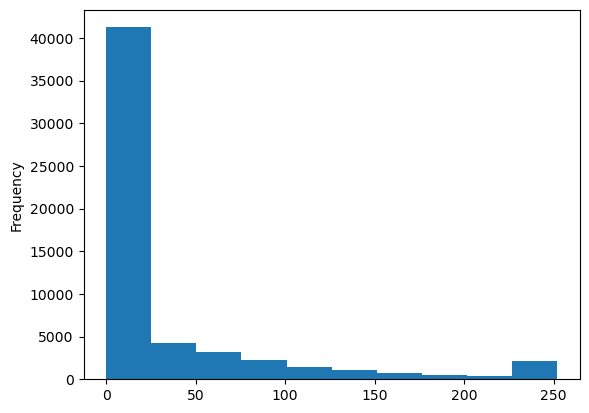

In [11]:
#Quick summary stats
print(annual_reviews['2022_estimates_nights_capped'].describe())
annual_reviews['2022_estimates_nights_capped'].plot.hist()

count    57330.000000
mean        49.121786
std         70.352006
min          0.000000
25%          0.000000
50%         18.000000
75%         72.000000
max        252.000000
Name: 2023_estimates_nights_capped, dtype: float64


<Axes: ylabel='Frequency'>

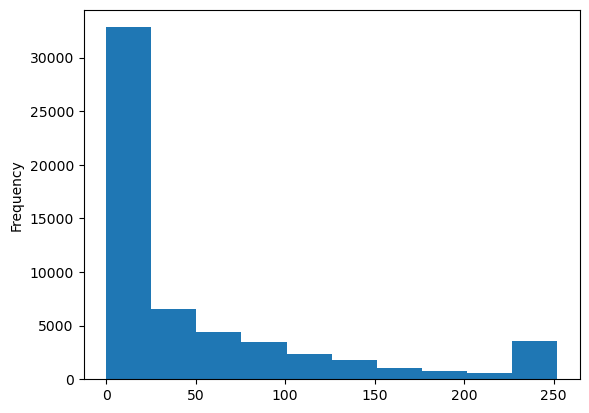

In [12]:
print(annual_reviews['2023_estimates_nights_capped'].describe())
annual_reviews['2023_estimates_nights_capped'].plot.hist()

In [13]:
#Load in LSOAs
#Data source: https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london
lsoa_url = 'data/LSOA_2011_London_gen_MHW.shp'
lsoas = gpd.read_file(lsoa_url)
columns_to_keep = ['LSOA11CD', 'LSOA11NM', 'geometry']
lsoas = lsoas.loc[:, columns_to_keep]
print(f'LSOA projection: {lsoas.crs}')
print(f'\nListings projection: {annual_reviews.crs}')

#Transform reviews projection
annual_reviews = annual_reviews.to_crs(lsoas.crs)
print(f'\nNew listings projection: {annual_reviews.crs}')

lsoas.rename(columns={'LSOA11CD': 'lsoa_code', 'LSOA11NM': 'lsoa_name'}, inplace=True)

lsoas.head()

LSOA projection: PROJCS["OSGB36 / British National Grid",GEOGCS["OSGB36",DATUM["Ordnance_Survey_of_Great_Britain_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.999601272],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]

Listings projection: epsg:4326

New listings projection: PROJCS["OSGB36 / British National Grid",GEOGCS["OSGB36",DATUM["Ordnance_Survey_of_Great_Britain_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scal

,lsoa_code,lsoa_name,geometry
0,E01000001,City of London 001A,"POLYGON ((532105.092 182011.23, 532162.491 181..."
1,E01000002,City of London 001B,"POLYGON ((532746.813 181786.891, 532671.688 18..."
2,E01000003,City of London 001C,"POLYGON ((532135.145 182198.119, 532158.25 182..."
3,E01000005,City of London 001E,"POLYGON ((533807.946 180767.77, 533649.063 180..."
4,E01000006,Barking and Dagenham 016A,"POLYGON ((545122.049 184314.931, 545271.917 18..."


In [14]:
#Step 6
#Join listings to LSOAs - within isn't working but intersects is! Why?
occupancy_by_lsoa = gpd.sjoin(lsoas, annual_reviews, how = 'left', predicate = 'intersects')

#Sum estimated nights per LSOA
lsoa_estimates = occupancy_by_lsoa.groupby('lsoa_code')[['2022_estimates_nights_capped', '2023_estimates_nights_capped']].sum()

#Add on LSOA name and geometry from previous dataframe
lsoa_estimates = lsoa_estimates.merge(lsoas, on='lsoa_code', how='left')
lsoa_estimates = gpd.GeoDataFrame(lsoa_estimates, geometry='geometry', crs=annual_reviews.crs)

In [15]:
#Step 7
lsoa_estimates['pct_occ_change'] = round(100*(lsoa_estimates['2023_estimates_nights_capped']-lsoa_estimates['2022_estimates_nights_capped'])/lsoa_estimates['2022_estimates_nights_capped'], 3)

<Axes: >

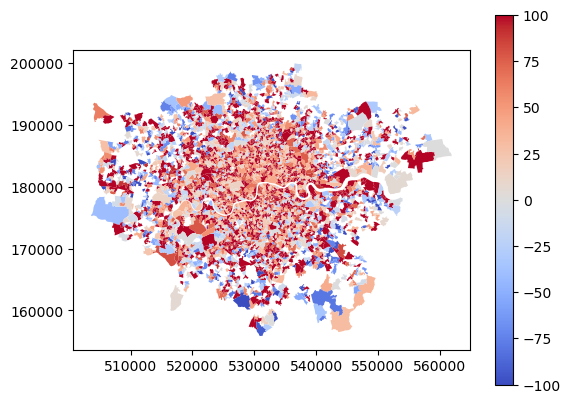

In [16]:
lsoa_estimates.pct_occ_change.min() #min is -100% (float -> 0)
lsoa_estimates.pct_occ_change.max() #max is infinity
lsoa_estimates[lsoa_estimates.pct_occ_change == np.inf] #this is all 0 -> float
lsoa_estimates[lsoa_estimates.pct_occ_change!=np.inf].plot(column = "pct_occ_change", cmap="coolwarm", legend=True, vmin=-100, vmax=100)
#So much heterogeneity!! Would wards be better?

<Axes: >

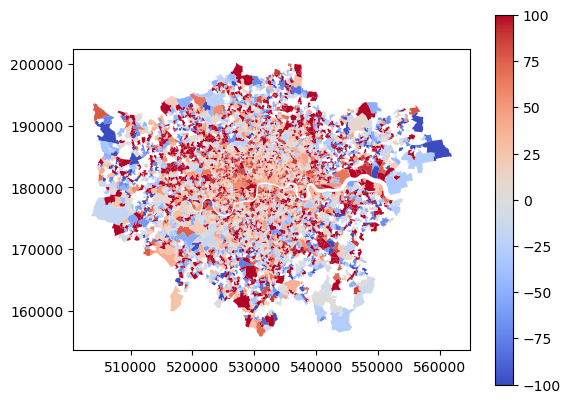

In [17]:
#Does this change if I use 2022-23 and 2023-24 categories instead?
#Step 1
annual_reviews2 = reviews.groupby(['listing_id', 'year_category']).size().unstack(fill_value=0)
annual_reviews2.rename(columns={'2022-2023': '2022_reviews', '2023-2024': '2023_reviews'}, inplace=True)
annual_reviews2 = annual_reviews2.reset_index()
annual_reviews2.columns.name = None

#Step 2
annual_reviews2['2022_reviews_rate_adjusted'] = annual_reviews2['2022_reviews']/0.5
annual_reviews2['2023_reviews_rate_adjusted'] = annual_reviews2['2023_reviews']/0.5

#Step 3
annual_reviews2 = annual_reviews2.merge(listings, how='left', left_on='listing_id', right_on='id').drop(columns = ['id'])
annual_reviews2[annual_reviews2.minimum_nights.isna()] #Join was fine - no nulls
annual_reviews2['estimated_stay'] = np.maximum(3, annual_reviews2.minimum_nights)

#Ensure annual_reviews is still a gdf
annual_reviews2 = gpd.GeoDataFrame(annual_reviews2, geometry='geometry', crs=listings.crs)

#Step 4
annual_reviews2['2022_estimated_nights'] = annual_reviews2['2022_reviews_rate_adjusted'] * annual_reviews2.estimated_stay
annual_reviews2['2023_estimated_nights'] = annual_reviews2['2023_reviews_rate_adjusted'] * annual_reviews2.estimated_stay

#Step 5
cap_nights = 12*21 #Wang et al. (2024) estimated cap of 21 nights per month
annual_reviews2['2022_estimates_nights_capped'] = np.minimum(cap_nights, annual_reviews2['2022_estimated_nights'])
annual_reviews2['2023_estimates_nights_capped'] = np.minimum(cap_nights, annual_reviews2['2023_estimated_nights'])

#Step 6
annual_reviews2 = annual_reviews2.to_crs(lsoas.crs)

#Join listings to LSOAs - within isn't working but intersects is! Why?
occupancy_by_lsoa2 = gpd.sjoin(lsoas, annual_reviews2, how = 'left', predicate = 'intersects')

#Sum estimated nights per LSOA
lsoa_estimates2 = occupancy_by_lsoa2.groupby('lsoa_code')[['2022_estimates_nights_capped', '2023_estimates_nights_capped']].sum()

#Add on LSOA name and geometry from previous dataframe
lsoa_estimates2 = lsoa_estimates2.merge(lsoas, on='lsoa_code', how='left')
lsoa_estimates2 = gpd.GeoDataFrame(lsoa_estimates2, geometry='geometry', crs=annual_reviews2.crs)

#Step 7
lsoa_estimates2['pct_occ_change'] = round(100*(lsoa_estimates2['2023_estimates_nights_capped']-lsoa_estimates2['2022_estimates_nights_capped'])/lsoa_estimates2['2022_estimates_nights_capped'], 3)

lsoa_estimates2.head()
lsoa_estimates2[lsoa_estimates2.pct_occ_change!=np.inf].plot(column = "pct_occ_change", cmap="coolwarm", legend=True, vmin=-100, vmax=100)


In [18]:
lsoa_estimates2['2023_estimates_nights_capped'].sum()-lsoa_estimates2['2022_estimates_nights_capped'].sum()

954812.0

In [19]:
lsoa_estimates['2023_estimates_nights_capped'].sum()-lsoa_estimates['2022_estimates_nights_capped'].sum()

1000426.0

In [20]:
lsoa_estimates2[lsoa_estimates2.pct_occ_change == np.inf] #this is all 0 -> float

,lsoa_code,2022_estimates_nights_capped,2023_estimates_nights_capped,lsoa_name,geometry,pct_occ_change
22,E01000024,0.0,12.0,Barking and Dagenham 008D,"POLYGON ((547104.969 185893.124, 547171.488 18...",inf
43,E01000046,0.0,54.0,Barking and Dagenham 017D,"POLYGON ((547292.948 183854.043, 546980.835 18...",inf
44,E01000048,0.0,30.0,Barking and Dagenham 021B,"POLYGON ((544633.054 183501.943, 544642.179 18...",inf
45,E01000049,0.0,22.0,Barking and Dagenham 021C,"POLYGON ((544992.046 183576.059, 544996.61 183...",inf
55,E01000059,0.0,12.0,Barking and Dagenham 013C,"POLYGON ((548679.596 184374.666, 548702.084 18...",inf
...,...,...,...,...,...,...
4678,E01032743,0.0,28.0,Ealing 010F,"POLYGON ((512775.732 182599.765, 512769.268 18...",inf
4714,E01033083,0.0,172.0,Hounslow 018F,"POLYGON ((514063 175711, 513899 175584, 513792...",inf
4747,E01033487,0.0,456.0,Islington 011F,"POLYGON ((530921 185272.027, 530808.642 185179...",inf
4776,E01033589,0.0,18.0,Redbridge 030H,"POLYGON ((544562.757 186870.773, 544601.979 18...",inf


So growth is still fast, but has somewhat slowed relative to the previous 9 months?

n.b. both maps aren't great as I have filtered out infinities

Either we need to keep in infinities *and* -100%, or remove both

Or aggregate by wards/MSOAs for clearer patterns? And to hopefully have fewer -100s/infinities?

In [21]:
#what is the avg number of airbnbs per lsoa?
#occupancy_by_lsoa2.groupby('lsoa_code')
occupancy_by_lsoa2.groupby('lsoa_code')[['listing_id']].count().describe()
#yeah i think we might have to do a different aggregation, if 25% of LSOAs only contain 2 listings - very susceptible to large changes

,listing_id
count,4835.000000
mean,11.853568
std,19.332544
min,0.000000
25%,2.000000
50%,6.000000
75%,14.000000
max,371.000000


## Trying again with MSOAs

In [22]:
#Focusing on 2023-2024

#Load in MSOAs
msoa_url = 'data/MSOA_2011_London_gen_MHW.shp'
msoas = gpd.read_file(msoa_url)
columns_to_keep = ['MSOA11CD', 'MSOA11NM', 'geometry']
msoas = msoas.loc[:, columns_to_keep]
print(f'MSOA projection: {msoas.crs}')
print(f'\nListings projection: {annual_reviews.crs}')

#Transform reviews projection (I did this above so commented it out here)
#annual_reviews = annual_reviews.to_crs(lsoas.crs)
#print(f'\nNew listings projection: {annual_reviews.crs}')

msoas.rename(columns={'MSOA11CD': 'msoa_code', 'MSOA11NM': 'msoa_name'}, inplace=True)

msoas.describe()

MSOA projection: PROJCS["OSGB36 / British National Grid",GEOGCS["OSGB36",DATUM["Ordnance_Survey_of_Great_Britain_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.999601272],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]

Listings projection: PROJCS["OSGB36 / British National Grid",GEOGCS["OSGB36",DATUM["Ordnance_Survey_of_Great_Britain_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.999601272],PARAMETER["fa

,msoa_code,msoa_name,geometry
count,983,983,983
unique,983,983,983
top,E02000001,City of London 001,MULTIPOLYGON (((531667.624000648 180534.991999...
freq,1,1,1


,msoa_code,msoa_name,geometry,index_right,listing_id,2022_reviews,2023_reviews,Pre-Cutoff,2022_reviews_rate_adjusted,2023_reviews_rate_adjusted,minimum_nights,estimated_stay,2022_estimated_nights,2023_estimated_nights,2022_estimates_nights_capped,2023_estimates_nights_capped
24,E02000026,Barnet 003,"POLYGON ((527797.197 196541.973, 527799.375 19...",47366.0,1.099118e+18,0.0,1.0,0.0,0.0,2.0,3.0,3.0,0.0,6.0,0.0,6.0
24,E02000026,Barnet 003,"POLYGON ((527797.197 196541.973, 527799.375 19...",15654.0,4.677340e+07,0.0,0.0,6.0,0.0,0.0,7.0,7.0,0.0,0.0,0.0,0.0
24,E02000026,Barnet 003,"POLYGON ((527797.197 196541.973, 527799.375 19...",18291.0,5.265525e+07,1.0,2.0,0.0,2.0,4.0,3.0,3.0,6.0,12.0,6.0,12.0
24,E02000026,Barnet 003,"POLYGON ((527797.197 196541.973, 527799.375 19...",38496.0,9.587376e+17,0.0,70.0,0.0,0.0,140.0,1.0,3.0,0.0,420.0,0.0,252.0
24,E02000026,Barnet 003,"POLYGON ((527797.197 196541.973, 527799.375 19...",23290.0,6.624709e+17,0.0,0.0,1.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0


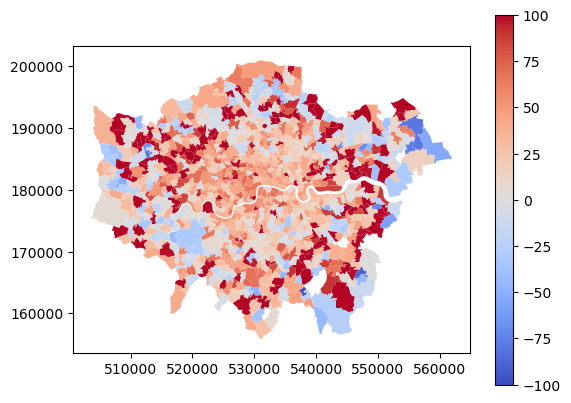

In [23]:
#Recalculate 2022-2023 with MSOAs
#Step 1
annual_reviews3 = reviews.groupby(['listing_id', 'year_category']).size().unstack(fill_value=0)
annual_reviews3.rename(columns={'2022-2023': '2022_reviews', '2023-2024': '2023_reviews'}, inplace=True)
annual_reviews3 = annual_reviews3.reset_index()
annual_reviews3.columns.name = None

#Step 2
annual_reviews3['2022_reviews_rate_adjusted'] = annual_reviews3['2022_reviews']/0.5
annual_reviews3['2023_reviews_rate_adjusted'] = annual_reviews3['2023_reviews']/0.5

#Step 3
annual_reviews3 = annual_reviews3.merge(listings, how='left', left_on='listing_id', right_on='id').drop(columns = ['id'])
annual_reviews3[annual_reviews3.minimum_nights.isna()] #Join was fine - no nulls
annual_reviews3['estimated_stay'] = np.maximum(3, annual_reviews3.minimum_nights)

#Ensure annual_reviews is still a gdf
annual_reviews3 = gpd.GeoDataFrame(annual_reviews3, geometry='geometry', crs=listings.crs)

#Step 4
annual_reviews3['2022_estimated_nights'] = annual_reviews3['2022_reviews_rate_adjusted'] * annual_reviews3.estimated_stay
annual_reviews3['2023_estimated_nights'] = annual_reviews3['2023_reviews_rate_adjusted'] * annual_reviews3.estimated_stay

#Step 5
cap_nights = 12*21 #Wang et al. (2024) estimated cap of 21 nights per month
annual_reviews3['2022_estimates_nights_capped'] = np.minimum(cap_nights, annual_reviews3['2022_estimated_nights'])
annual_reviews3['2023_estimates_nights_capped'] = np.minimum(cap_nights, annual_reviews3['2023_estimated_nights'])

#Step 6
annual_reviews3 = annual_reviews3.to_crs(msoas.crs)

#Join listings to MSOAs - within isn't working but intersects is! Why?
occupancy_by_msoa3 = gpd.sjoin(msoas, annual_reviews3, how = 'left', predicate = 'intersects')

#Sum estimated nights per MSOA
msoa_estimates3 = occupancy_by_msoa3.groupby('msoa_code')[['2022_estimates_nights_capped', '2023_estimates_nights_capped']].sum()

#Add on MSOA name and geometry from previous dataframe
msoa_estimates3 = msoa_estimates3.merge(msoas, on='msoa_code', how='left')
msoa_estimates3 = gpd.GeoDataFrame(msoa_estimates3, geometry='geometry', crs=annual_reviews3.crs)

#Step 7
msoa_estimates3['pct_occ_change'] = round(100*(msoa_estimates3['2023_estimates_nights_capped']-msoa_estimates3['2022_estimates_nights_capped'])/msoa_estimates3['2022_estimates_nights_capped'], 3)

msoa_estimates3.head()
msoa_estimates3[msoa_estimates3.pct_occ_change!=np.inf].plot(column = "pct_occ_change", cmap="coolwarm", legend=True, vmin=-100, vmax=100)

#msoa_estimates3[(msoa_estimates3.pct_occ_change!=np.inf) & (msoa_estimates3.pct_occ_change<200)].pct_occ_change.plot.hist(bins=20)

#Work out scale - and maybe cap percentage changes?
#Remove -100s and infinities

msoa_estimates3.loc[np.isfinite(msoa_estimates3.pct_occ_change), :].loc[
    msoa_estimates3.loc[np.isfinite(msoa_estimates3.pct_occ_change), 'pct_occ_change'].idxmax()
]

occupancy_by_msoa3[occupancy_by_msoa3.msoa_code=='E02000026']
#change listing id data type
#look at this in more detail!! work out what to do with these massive increases. it's a problem with percentages

#1) look into problems - work out what it is and change method
#2) Use wards instead
#3) absolute change divided by area or another metric (but this is probs a bad idea)

#(and sort out infs and -100)

## Trying with wards

In [24]:
#Load in wards
wards_url = 'data/London_Ward_CityMerged.shp'
wards = gpd.read_file(wards_url)
columns_to_keep = ['NAME', 'GSS_CODE', 'geometry']
wards = wards.loc[:, columns_to_keep]
print(f'Wards projection: {wards.crs}')
print(f'\nListings projection: {annual_reviews.crs}')

#Transform reviews projection (I did this above so commented it out here)
#annual_reviews = annual_reviews.to_crs(lsoas.crs)
#print(f'\nNew listings projection: {annual_reviews.crs}')

wards.rename(columns={'GSS_CODE': 'ward_code', 'NAME': 'ward_name'}, inplace=True)

wards.describe()

Wards projection: EPSG:27700

Listings projection: PROJCS["OSGB36 / British National Grid",GEOGCS["OSGB36",DATUM["Ordnance_Survey_of_Great_Britain_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.999601272],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


,ward_name,ward_code,geometry
count,633,633,633
unique,615,633,633
top,Woodside,E05000405,POLYGON ((516401.59596424643 160201.8020401798...
freq,2,1,1


count    632.000000
mean      41.246191
std       75.366408
min      -83.775000
25%       10.199000
50%       30.854000
75%       53.179500
max      942.857000
Name: pct_occ_change, dtype: float64

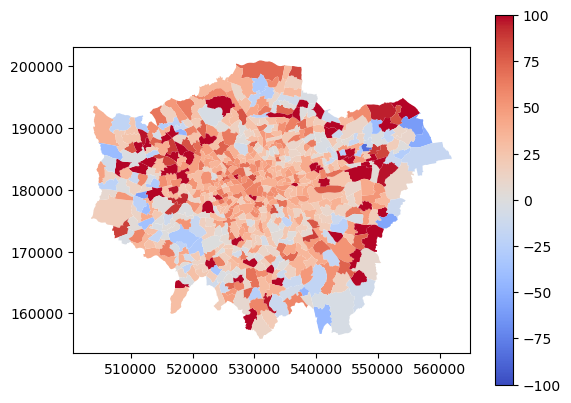

In [25]:
#Recalculate 2022-2023 with wards
#Step 1
annual_reviews4 = reviews.groupby(['listing_id', 'year_category']).size().unstack(fill_value=0)
annual_reviews4.rename(columns={'2022-2023': '2022_reviews', '2023-2024': '2023_reviews'}, inplace=True)
annual_reviews4 = annual_reviews4.reset_index()
annual_reviews4.columns.name = None

#Step 2
annual_reviews4['2022_reviews_rate_adjusted'] = annual_reviews4['2022_reviews']/0.5
annual_reviews4['2023_reviews_rate_adjusted'] = annual_reviews4['2023_reviews']/0.5

#Step 3
annual_reviews4 = annual_reviews4.merge(listings, how='left', left_on='listing_id', right_on='id').drop(columns = ['id'])
annual_reviews4[annual_reviews4.minimum_nights.isna()] #Join was fine - no nulls
annual_reviews4['estimated_stay'] = np.maximum(3, annual_reviews4.minimum_nights)

#Ensure annual_reviews is still a gdf
annual_reviews4 = gpd.GeoDataFrame(annual_reviews4, geometry='geometry', crs=listings.crs)

#Step 4
annual_reviews4['2022_estimated_nights'] = annual_reviews4['2022_reviews_rate_adjusted'] * annual_reviews4.estimated_stay
annual_reviews4['2023_estimated_nights'] = annual_reviews4['2023_reviews_rate_adjusted'] * annual_reviews4.estimated_stay

#Step 5
cap_nights = 12*21 #Wang et al. (2024) estimated cap of 21 nights per month
annual_reviews4['2022_estimates_nights_capped'] = np.minimum(cap_nights, annual_reviews4['2022_estimated_nights'])
annual_reviews4['2023_estimates_nights_capped'] = np.minimum(cap_nights, annual_reviews4['2023_estimated_nights'])

#Step 6
annual_reviews4 = annual_reviews4.to_crs(wards.crs)

#Join listings to wards - within isn't working but intersects is! Why?
occupancy_by_wards4 = gpd.sjoin(wards, annual_reviews4, how = 'left', predicate = 'intersects')

#Sum estimated nights per wards
wards_estimates4 = occupancy_by_wards4.groupby('ward_code')[['2022_estimates_nights_capped', '2023_estimates_nights_capped']].sum()

#Add on ward name and geometry from previous dataframe
wards_estimates4 = wards_estimates4.merge(wards, on='ward_code', how='left')
wards_estimates4 = gpd.GeoDataFrame(wards_estimates4, geometry='geometry', crs=annual_reviews4.crs)

#Step 7
wards_estimates4['pct_occ_change'] = round(100*(wards_estimates4['2023_estimates_nights_capped']-wards_estimates4['2022_estimates_nights_capped'])/wards_estimates4['2022_estimates_nights_capped'], 3)

wards_estimates4.head()
wards_estimates4[wards_estimates4.pct_occ_change!=np.inf].plot(column = "pct_occ_change", cmap="coolwarm", legend=True, vmin=-100, vmax=100)

wards_estimates4.pct_occ_change.describe()

In [26]:
annual_reviews4.sample(10)

,listing_id,2022_reviews,2023_reviews,Pre-Cutoff,2022_reviews_rate_adjusted,2023_reviews_rate_adjusted,minimum_nights,geometry,estimated_stay,2022_estimated_nights,2023_estimated_nights,2022_estimates_nights_capped,2023_estimates_nights_capped
52480,1163978079655959971,0,5,0,0.0,10.0,1,POINT (528522.474 172733.174),3,0.0,30.0,0.0,30.0
13652,41083341,8,3,15,16.0,6.0,3,POINT (545280.341 183830.183),3,48.0,18.0,48.0,18.0
26342,734067240052577111,4,0,0,8.0,0.0,4,POINT (527537.844 175327.414),4,32.0,0.0,32.0,0.0
33901,893961002561369147,0,1,0,0.0,2.0,3,POINT (519136.005 190330.32),3,0.0,6.0,0.0,6.0
17292,51168772,55,35,20,110.0,70.0,1,POINT (534470.681 190772.313),3,330.0,210.0,252.0,210.0
4581,15250865,0,0,7,0.0,0.0,1,POINT (530638.547 180820.64),3,0.0,0.0,0.0,0.0
9387,28798472,2,0,4,4.0,0.0,5,POINT (532509.283 182357.95),5,20.0,0.0,20.0,0.0
39847,979576264563231597,0,4,0,0.0,8.0,1,POINT (549056.16 186062.827),3,0.0,24.0,0.0,24.0
39565,975228985627224809,0,18,0,0.0,36.0,3,POINT (526478.565 180973.448),3,0.0,108.0,0.0,108.0
12912,39189468,4,0,1,8.0,0.0,2,POINT (534946.76 184122.566),3,24.0,0.0,24.0,0.0


<Axes: ylabel='Frequency'>

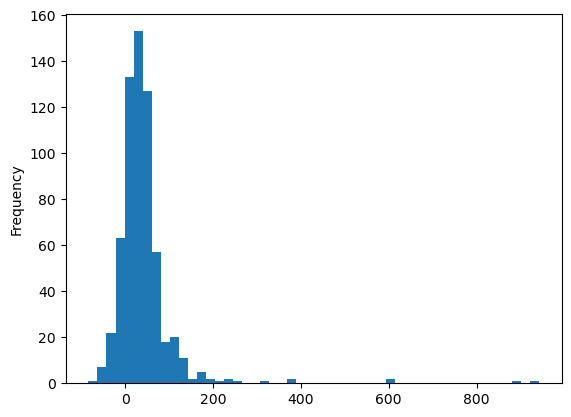

In [27]:
wards_estimates4[wards_estimates4.pct_occ_change!=np.inf].pct_occ_change.plot.hist(bins=50)

**Next steps/takeaways:**
- More recent data seems to show more decreases - fits with what we thought
- LSOAs don't work, wards are the best scale probably as they don't have as many infinities
    - But not as much detail as MSOAs
    - Ward justification: at this scale enough cumulative listings to reduce instability from individual listing openings/closures
- Need to look into massive percentage changes: need to look into individual outlier

In [28]:
wards_estimates4.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 633 entries, 0 to 632
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   ward_code                     633 non-null    object  
 1   2022_estimates_nights_capped  633 non-null    float64 
 2   2023_estimates_nights_capped  633 non-null    float64 
 3   ward_name                     633 non-null    object  
 4   geometry                      633 non-null    geometry
 5   pct_occ_change                632 non-null    float64 
dtypes: float64(3), geometry(1), object(2)
memory usage: 29.8+ KB


In [29]:
import matplotlib.pyplot as plt  # Graphics
from matplotlib import colors
import seaborn  # Graphics
import geopandas  # Spatial data manipulation
import pandas  # Tabular data manipulation
import rioxarray  # Surface data manipulation
import xarray  # Surface data manipulation
from pysal.explore import esda  # Exploratory Spatial analytics
from pysal.lib import weights  # Spatial weights
import contextily  # Background tiles

/opt/conda/lib/python3.11/site-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


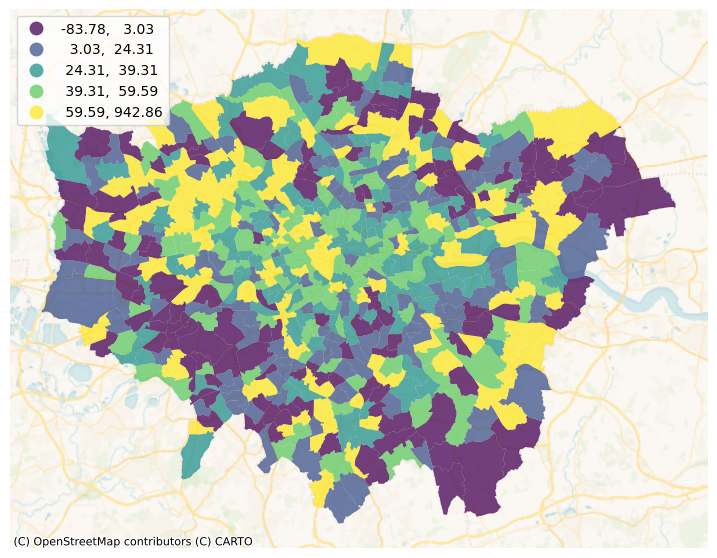

In [30]:
f, ax = plt.subplots(1, figsize=(9, 9))
# Build choropleth
wards_estimates4.plot(
    column="pct_occ_change",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax,
)
# Add basemap
contextily.add_basemap(
    ax,
    crs=wards_estimates4.crs,
    source=contextily.providers.CartoDB.VoyagerNoLabels,
)
# Remove axes
ax.set_axis_off();

Local Moran's I vs Moran's I 

Moran’s I does not indicate areas within the map where specific types of values (e.g., high, low) are clustered, or instances of explicit dispersion. In other words, Moran’s I can tell us whether values in our map cluster together (or disperse) overall, but it **will not** inform us about where specific clusters (or outliers) are.

Local measures of spatial autocorrelation focus on the relationships between each observation and its surroundings, rather than providing a single summary of these relationships across the map. Global Moran's I can be decomposed into a collection of local ones - for example Local Indicators of Spatial Association (LISAs). 

In [31]:
# Generate W from the GeoDataFrame
w = weights.distance.KNN.from_dataframe(wards_estimates4, k=5)
# Row-standardization
w.transform = "R"

In [33]:
wards_estimates4.loc[201, 'pct_occ_change'] = -100
wards_estimates4["w_pct_occ_change"] = weights.lag_spatial(w, wards_estimates4['pct_occ_change'])
wards_estimates4["pct_occ_change_std"] = wards_estimates4["pct_occ_change"]- wards_estimates4["pct_occ_change"].mean()
wards_estimates4["w_pct_occ_change_std"] = weights.lag_spatial(w, wards_estimates4['pct_occ_change_std'])


# standard deviation is for their respective centered versions
# testing stage below to use if any error occurs during Moran's I calculations 
wards_estimates4['random_column'] = np.random.randint(-83, 942, size=len(wards_estimates4))

In [58]:
print(wards_estimates4["pct_occ_change"].min())
print(wards_estimates4["pct_occ_change"].max())

# test code to see if there is any NAN or NA values to make sure calculation runs smoothly 
# rows_with_nan = wards_estimates4[wards_estimates4["pct_occ_change"].isna()]
# print(rows_with_nan)

-100.0
942.857


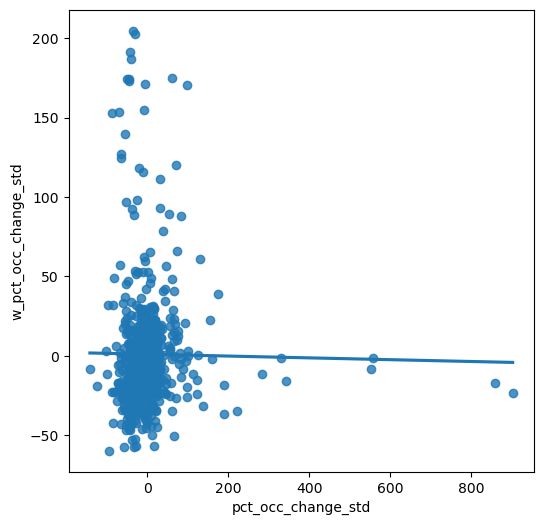

In [35]:
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(
    x="pct_occ_change_std", y="w_pct_occ_change_std", data=wards_estimates4, ci=None
)
plt.show()

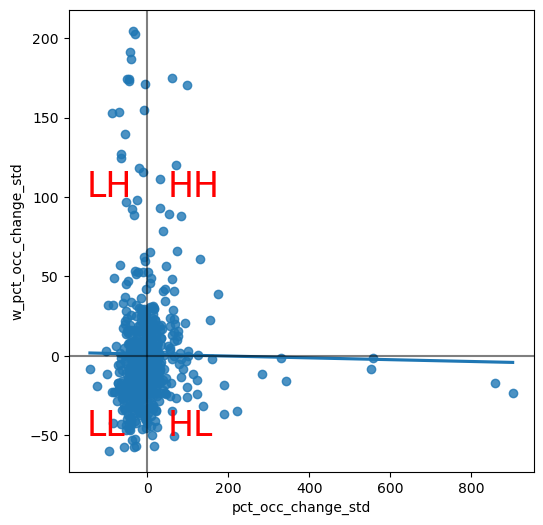

In [36]:
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(
    x="pct_occ_change_std", y="w_pct_occ_change_std", data=wards_estimates4, ci=None
)
# Add vertical and horizontal lines
plt.axvline(0, c="k", alpha=0.5)
plt.axhline(0, c="k", alpha=0.5)
# Add text labels for each quadrant
plt.text(50, 100, "HH", fontsize=25, c="r")
plt.text(50, -50, "HL", fontsize=25, c="r")
plt.text(-150, 100, "LH", fontsize=25, c="r")
plt.text(-150, -50, "LL", fontsize=25, c="r")
# Display
plt.show()


Using standardized values, we can immediately divide each variable (percentage change, and its spatial lag) in two groups: those with above-average change, which have positive standardized values; and those with below-average change, which feature negative standardized values. Applying this thinking to both the percentage change and its spatial lag, divides a Moran scatterplot into four quadrants. Each of them captures a situation based on whether a given area displays a value above the mean (high) or below (low) in either the original variable (Pct_occ_change) or its spatial lag (w_Pct_occ_change_std). 

The percentage of occupancy change (Pct_occ_change) and its spatial lag (w_Pct_occ_change) are transformed into standardized values (z-scores). Standardization makes it easier to compare the data as it centers the mean at 0, with values above the mean being positive and below the mean being negative.

- Quadrant I (High-High): Areas with above-average Pct_change and above-average spatial lag. These are regions where high percent change in occupancy areas are surrounded by similarly high change areas, indicating positive spatial autocorrelation.

- Quadrant II (Low-High): Areas with below-average Pct_change but above-average spatial lag. These regions have low change areas surrounded by high change neighbors.

- Quadrant III (Low-Low): Areas with below-average Pct_change and below-average spatial lag. These are regions where low change areas are surrounded by similarly low change neighbors, again indicating positive spatial autocorrelation.

- Quadrant IV (High-Low): Areas with above-average Pct_change but below-average spatial lag. These regions have high change areas surrounded by low change neighbors, representing negative spatial autocorrelation.

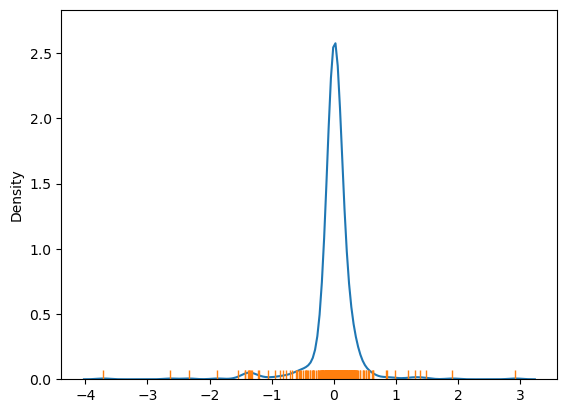

In [37]:
lisa = esda.moran.Moran_Local(wards_estimates4["pct_occ_change"], w)
ax = seaborn.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
seaborn.rugplot(lisa.Is, ax=ax);



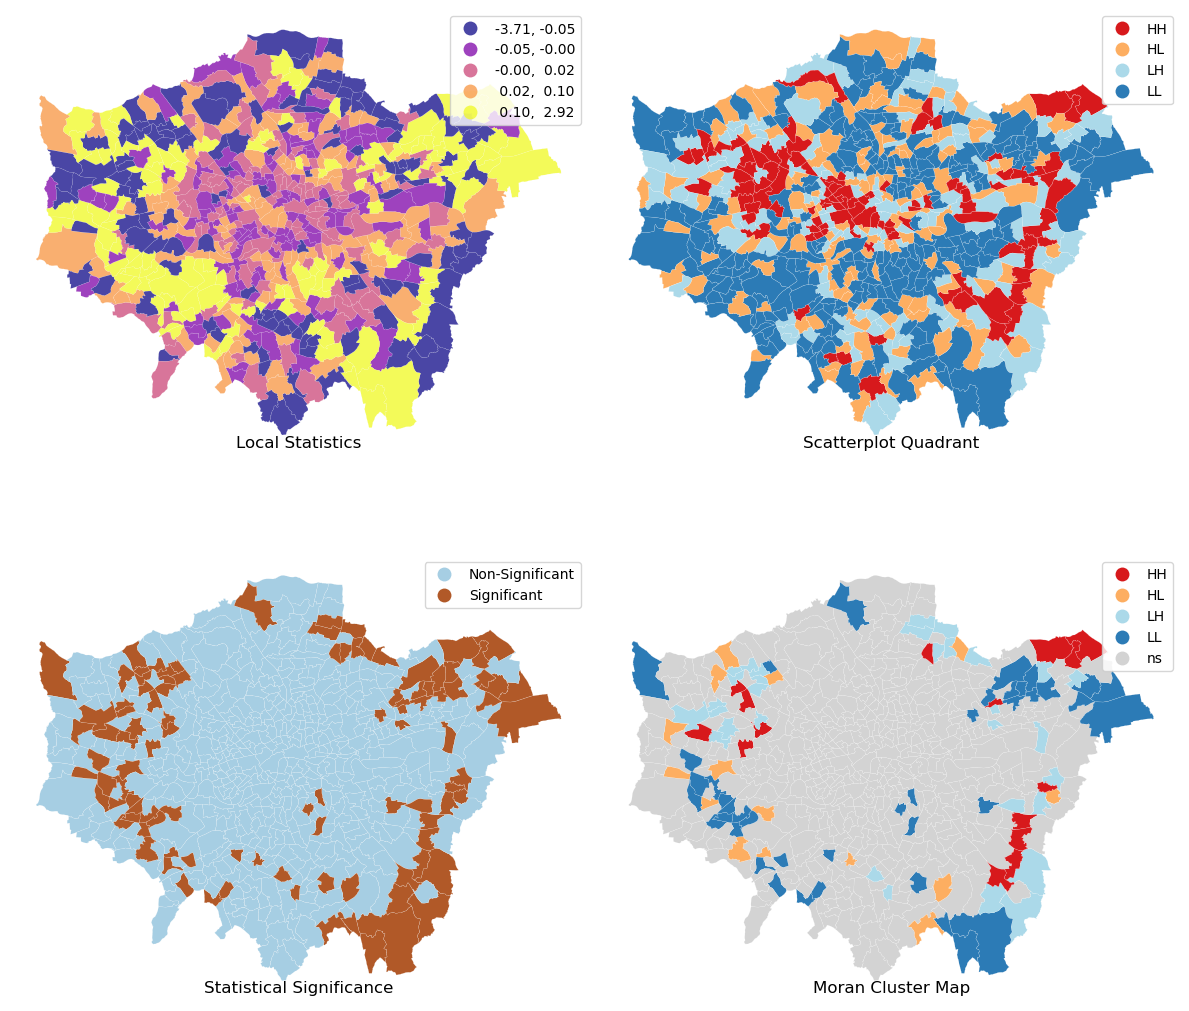

In [132]:
from splot import esda as esdaplot
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
wards_estimates4.assign(
    Is=lisa.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)

# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quadrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, wards_estimates4, p=1, ax=ax)

# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
#
# Find out significant observations
labels = pandas.Series(
    1 * (lisa.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=wards_estimates4.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
wards_estimates4.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)


# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quadrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, wards_estimates4, p=0.05, ax=ax)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimize in-between white space
f.tight_layout()

# Display the figure
plt.show()

The purple and yellow locations in the top-right map in the display the largest magnitude (positive and negative values) for the local statistics 
. Yet, remember this signifies positive spatial autocorrelation, which can be of high or low values. This map thus cannot distinguish between areas with large negative change for airbnb occupancy and those with large positive change in occupancy. 

To statistical significance, the bottom-left map distinguishes those polygons whose pseudo-value is above (“Non-Significant”) or below (“Significant”) the threshold value of 5% we use in this context. 

Together, the 4th “cluster map” extracts significant observations -those that are highly unlikely to have come from pure chance and illustrates the clustering of large negative and positive changes. Most of the negative change are clustered around outer london, and there seems to be hotspots of large positive airbnb occupancy changes in north-west, north-east, and south-east London. 

In [39]:
(lisa.p_sim < 0.05).sum() * 100 / len(lisa.p_sim)

14.375987361769353

A little over 14% of the local authorities are considered, by this analysis, to be part of a spatial cluster.

In [40]:
go_i = esda.getisord.G_Local(wards_estimates4["pct_occ_change"], w)
# Gi*
go_i_star = esda.getisord.G_Local(wards_estimates4["pct_occ_change"], w, star=True)

/opt/conda/lib/python3.11/site-packages/esda/getisord.py:421: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  w, star = _infer_star_and_structure_w(w, star, transform)


In [49]:
def g_map(g, db, ax):
    """
    Create a cluster map
    ...

    Arguments
    ---------
    g      : G_Local
             Object from the computation of the G statistic
    db     : GeoDataFrame
             Table aligned with values in `g` and containing
             the geometries to plot
    ax     : AxesSubplot
             `matplotlib` axis to draw the map on

    Returns
    -------
    ax     : AxesSubplot
             Axis with the map drawn
    """
    ec = "0.8"

    # Break observations into significant or not
    sig = g.p_sim < 0.05

    # Plot non-significant clusters
    ns = wards_estimates4.loc[sig == False, "geometry"]
    ns.plot(ax=ax, color="lightgrey", edgecolor=ec, linewidth=0.1)
    
    # Plot HH clusters
    hh = wards_estimates4.loc[(g.Zs > 0) & (sig == True), "geometry"]
    hh.plot(ax=ax, color="red", edgecolor=ec, linewidth=0.1)
    
    # Plot LL clusters
    ll = wards_estimates4.loc[(g.Zs < 0) & (sig == True), "geometry"]
    ll.plot(ax=ax, color="blue", edgecolor=ec, linewidth=0.1)
    
    # Style and draw
    contextily.add_basemap(ax,
        crs=wards_estimates4.crs,
        source=contextily.providers.CartoDB.VoyagerNoLabels,
    )
    
    # Flag to add a star to the title if it's G_i*
    st = ""
    if g.star:
        st = "*"
    # Add title
    ax.set_title(f"G{st} statistic for % Change in Airbnb Occupancy", size=15)
    # Remove axis for aesthetics
    ax.set_axis_off()

    return ax

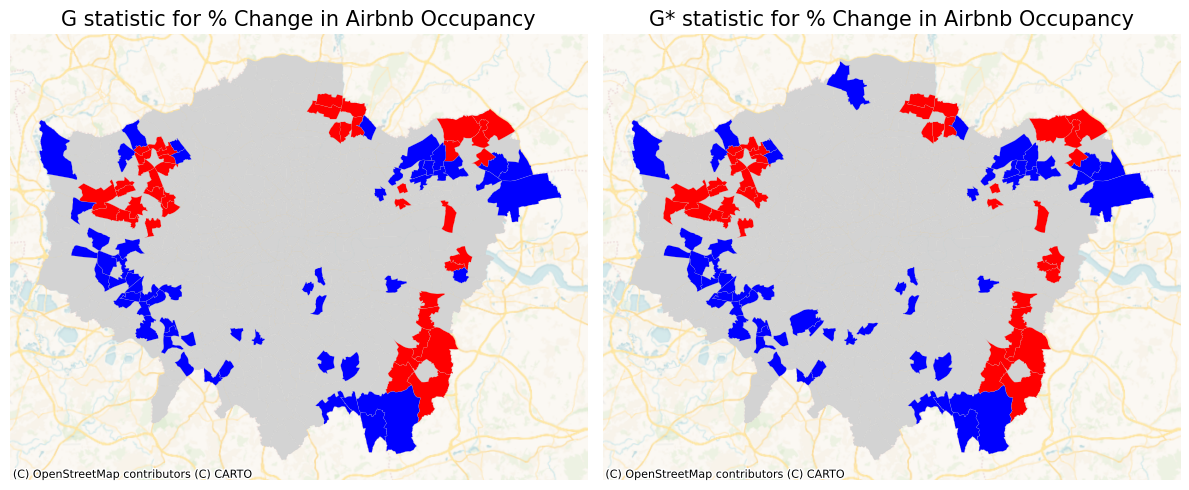

In [50]:
# Set up figure and axes
f, axs = plt.subplots(1, 2, figsize=(12, 6))
# Loop over the two statistics
for g, ax in zip([go_i, go_i_star], axs.flatten()):
    # Generate the statistic's map
    ax = g_map(g, wards_estimates4, ax)
# Tight layout to minimise blank spaces
f.tight_layout()
# Render
plt.show()

Use Moran’s I when you are interested in both the global spatial structure and the nature of local clusters (including outliers like HL or LH).

Use Getis-Ord when you need to identify areas of intense activity or concentration (hotspots/coldspots) without concern for negative spatial associations.

The local Moran's I statistic (on its own) gives an indication of cluster/outlier status, and the local Getis shows which side of the hotspot/coldspot divide the observation is on.

Moran's I give more information but can be tricky to illustrate because of multiple HL,LL etc classification, but Getis is a lot more simple - either hot or cold. 

In [65]:
wards_estimates4.head(3)

,ward_code,2022_estimates_nights_capped,2023_estimates_nights_capped,ward_name,geometry,pct_occ_change,w_pct_occ_change,pct_occ_change_std,w_pct_occ_change_std,random_column
0,E05000026,2294.0,2992.0,Abbey,"POLYGON ((544735.196 184076.498, 544726.596 18...",30.427,93.9520,-10.596054,52.928946,917
1,E05000027,144.0,296.0,Alibon,"POLYGON ((547932.4 184916.598, 547944.8 184924...",105.556,70.1070,64.532946,29.083946,455
2,E05000028,764.0,540.0,Becontree,"POLYGON ((546209.396 185783.599, 546219.299 18...",-29.319,30.5094,-70.342054,-10.513654,235


In [69]:
# ward names of positive change clusters 
sig = g.p_sim < 0.05
hh = wards_estimates4.loc[(g.Zs > 0) & (sig == True), ["geometry",'ward_name']]
hh.head(5)

,geometry,ward_name
0,"POLYGON ((544735.196 184076.498, 544726.596 18...",Abbey
12,"POLYGON ((549072.799 183605.103, 549074.102 18...",River
46,"POLYGON ((516701.7 188368.599, 516891.501 1885...",Kenton
49,"POLYGON ((517663.799 186262.102, 517630.498 18...",Northwick Park
54,"POLYGON ((515484.902 185501.2, 515487.103 1855...",Sudbury


In [70]:
# ward names of negative change clusters 
sig = g.p_sim < 0.05
ll = wards_estimates4.loc[(g.Zs < 0) & (sig == True), ["geometry",'ward_name']]
ll.head(5)

,geometry,ward_name
3,"POLYGON ((548874.2 188496.303, 548843.199 1884...",Chadwell Heath
16,"POLYGON ((549410.698 187450.702, 549391.199 18...",Whalebone
52,"POLYGON ((520765.097 189629.099, 520714.101 18...",Queensbury
60,"POLYGON ((540373.6 157530.397, 540361.199 1575...",Biggin Hill
70,"POLYGON ((545237.403 156802.195, 545233.701 15...",Darwin
